# Implementing the EffTox Dose-Finding Design in the Matchpoint Trials

This tutorial complements the manuscript _Implementing the EffTox Dose-Finding Design in the Matchpoint Trial_ (Brock _et al_.,in submission). Please consult the paper for the clinical background, the methodology details, and full explanation of the terminology.

## Posterior Utility

In this notebook, we illustrate posterior utility plots of selected doses using the EffTox design in the seamless phase I/II dose-finding clinical trial, Matchpoint.

In [15]:
import numpy as np
from scipy.stats import norm

from clintrials.dosefinding.efftox import EffTox, LpNormCurve

In [2]:
%matplotlib inline

In [3]:
real_doses = [7.5, 15, 30, 45]
trial_size = 30
cohort_size = 3
first_dose = 3
prior_tox_probs = (0.025, 0.05, 0.1, 0.25)
prior_eff_probs = (0.2, 0.3, 0.5, 0.6)
tox_cutoff = 0.40
eff_cutoff = 0.45
tox_certainty = 0.05
eff_certainty = 0.03

In [4]:
mu_t_mean, mu_t_sd = -5.4317, 2.7643
beta_t_mean, beta_t_sd = 3.1761, 2.7703
mu_e_mean, mu_e_sd = -0.8442, 1.9786
beta_e_1_mean, beta_e_1_sd = 1.9857, 1.9820
beta_e_2_mean, beta_e_2_sd = 0, 0.2
psi_mean, psi_sd = 0, 1
efftox_priors = [
    norm(loc=mu_t_mean, scale=mu_t_sd),
    norm(loc=beta_t_mean, scale=beta_t_sd),
    norm(loc=mu_e_mean, scale=mu_e_sd),
    norm(loc=beta_e_1_mean, scale=beta_e_1_sd),
    norm(loc=beta_e_2_mean, scale=beta_e_2_sd),
    norm(loc=psi_mean, scale=psi_sd),
    ]

The above parameters are explained in the manuscript.

In [5]:
hinge_points = [(0.4, 0), (1, 0.7), (0.5, 0.4)]
metric = LpNormCurve(hinge_points[0][0], hinge_points[1][1], hinge_points[2][0], hinge_points[2][1])

In [6]:
et = EffTox(real_doses, efftox_priors, tox_cutoff, eff_cutoff, tox_certainty, eff_certainty, metric, trial_size,
            first_dose)

The EffTox class is an object-oriented implementation of the trial design by Thall & Cook (Thall, P. F., & Cook, J. D. (2004). Dose-Finding Based on Efficacy-Toxicity Trade-Offs. Biometrics, 60(3), 684–693.)

## After observing outcomes 3NTE

Outcomes for a patient are represented by a three item tuple, where:

- first item is 1-based dose-index give (i.e. 3 is dose-level 3);
- second item is 1 if toxicity happened, else 0;
- third item is 1 if efficacy happened, else 0.

Outcomes for several patients are represented as lists:

In [7]:
outcomes1 = [(3, 0, 0), (3, 1, 0), (3, 0, 1)]

In [8]:
np.random.seed(123)
et.update(outcomes1, n=10**6)

4

In this instance, escalation to dose-level 4 is recommended.

In [9]:
et.tabulate()

,Dose,N,Efficacies,Toxicities,EffRate,ToxRate,P(Eff),P(Tox),P(AccEff),P(AccTox),Admissible,Utility
0,1,0,0,0,NaN,NaN,0.160180,0.034322,0.132111,0.973928,True,-0.400358
1,2,0,0,0,NaN,NaN,0.207549,0.049932,0.132074,0.976966,True,-0.322274
2,3,3,1,1,0.333333,0.333333,0.375305,0.232804,0.324318,0.826467,True,-0.087531
3,4,0,0,0,NaN,NaN,0.517751,0.521629,0.602753,0.354400,True,-0.083545


We see that all doses are admissible in this instance, and that the utilities of dose-levels 3 and 4 are very similar. _Dose Ambivalence_ is the likely result, i.e. after observing 3NTE in the Matchpoint trial, the design would have recommended dose 3 or dose 4. The reason is made plain by the plot below.

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


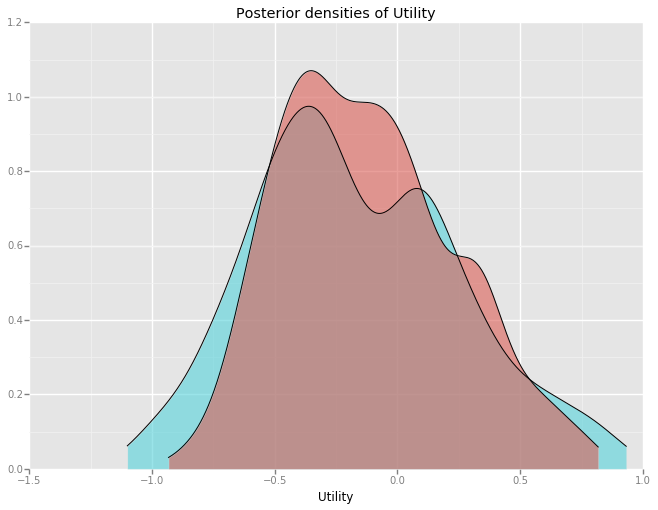

<ggplot: (284607041)>

In [10]:
et.plot_posterior_utility_density(include_doses=[3,4], boot_samps=1000)

The posterior distributions of the utility of doses 3 and 4 largely occupy the same space so picking between them is difficult. In the Ambivalence.ipynb tutorial, we demonstrate a method for dealing with dose ambivalence.

The plot above is similar (but not identical) to Figure 2 in the publication. I used the R package `ggplot2` to produce the plots for the paper because the R package is more mature than the Python version. For instance, I could not get a legend to appear in Python. 

## After observing outcomes 2NNN 3ENN 4EBE 3TEE 4NEE

In [11]:
outcomes2 = [
    (2, 0, 0), (2, 0, 0), (2, 0, 0),
    (3, 0, 1), (3, 0, 0), (3, 0, 0),
    (4, 0, 1), (4, 1, 1), (4, 0, 1),
    (3, 1, 0), (3, 0, 1), (3, 0, 1),
    (4, 0, 0), (4, 0, 1), (4, 0, 1),
            ]

In [12]:
et.reset()
et.update(outcomes2, n=10**6)

4

In [13]:
et.tabulate()

,Dose,N,Efficacies,Toxicities,EffRate,ToxRate,P(Eff),P(Tox),P(AccEff),P(AccTox),Admissible,Utility
0,1,0,0,0,NaN,NaN,0.037049,0.020184,0.006575,0.993906,False,-0.605108
1,2,3,0,0,0.000000,0.000000,0.131565,0.028580,0.025895,0.998559,False,-0.447828
2,3,6,3,1,0.500000,0.166667,0.504060,0.078842,0.644865,0.999206,True,0.166992
3,4,6,5,1,0.833333,0.166667,0.774475,0.206620,0.984291,0.886853,True,0.527321


Dose 4 is now clearly the preferable dose. 

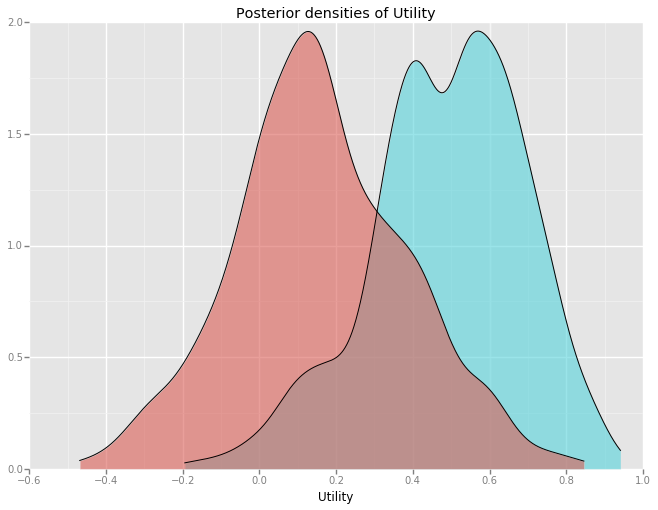

<ggplot: (270116133)>

In [14]:
et.plot_posterior_utility_density(include_doses=[3,4], boot_samps=1000)

That is reflected in the estimates of the posterior utility curves.

The plot above is similar (but not identical) to Figure 3 in the publication.